# Chapter 3: Risk

## The Important Lessons

- Risk defined as the standard deviation of return
- Risks are not additive
- Many institutional investors care more about active and residual risk rather than total risk
- Active risk primarily depends on size of active position not size of benchmark position
- Risk models identify the important sources of risk and its components

## Properties of Risk

### The Source of Risk

Risk comes from the probability distribution of returns. We can get a sense of the distribution via a histogram:

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline 

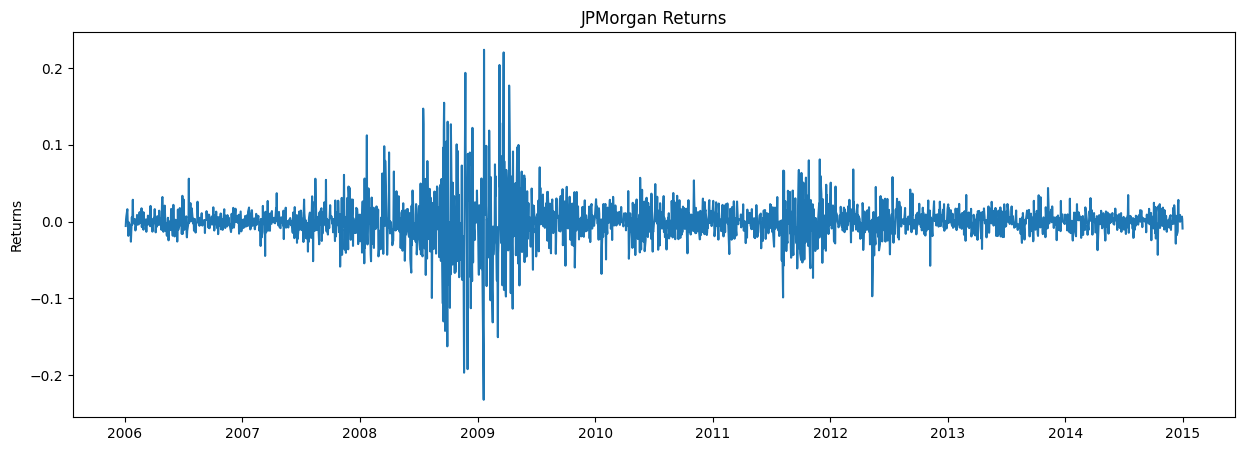

In [2]:
START = "2006-01-01"
END = "2015-01-01"
START_EX = "2015-02-01"
END_EX = "2016-06-01"

jpm = yf.download("JPM", start=START, end=END, progress=False)
#jpm = DataReader('JPM',  'yahoo', datetime(2006,1,1), datetime(2015,1,1))
jpm_returns = pd.DataFrame(np.diff(np.log(jpm['Close'].values.ravel())))
jpm_returns.index = jpm.index.values[1:jpm.index.values.shape[0]]
jpm_returns.columns = ['JPMorgan Returns']

plt.figure(figsize=(15,5))
plt.plot(jpm_returns)
plt.ylabel('Returns')
plt.title('JPMorgan Returns')
plt.show()

Text(0.5, 0, 'Daily Returns')

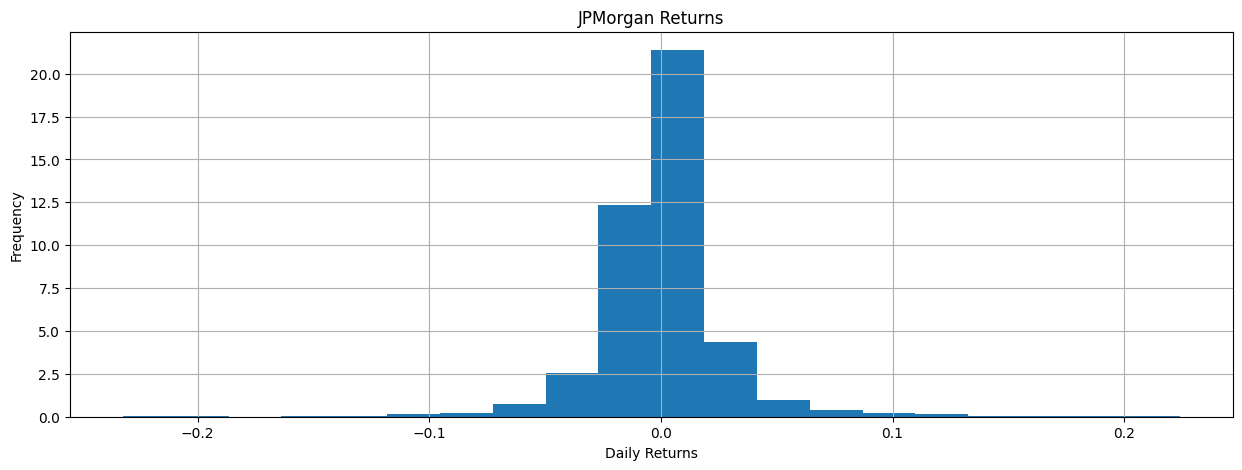

In [3]:
jpm_returns.hist(figsize=(15,5),bins=20, density=True)
plt.ylabel("Frequency")
plt.xlabel("Daily Returns")

### Defining Risk

Rather than using the entire probability distribution to inform risk, the authors try to capture the essentials of risk. This creates some shortcomings. If we assume normally distributed returns, then all the risk measures are products of the mean and standard deviation.

Standard deviation was Markowitz's definition of risk. Knowing just standard deviations and covariances, we can calculate portfolio standard deviations. 

### Limitations with Standard Deviation

One criticism is that standard deviation measures the possibility of returns above and below the mean. Most investors would define risk as small or negative returns. An alternative measure is **semivariance** or **downside risk**.

Semivariance is calculated similarly to variance but only using returns below the mean. If the returns are symmetric then the semivariance is exactly one-half of the variance. Downside risk has varying definitions but many just assume it is the square root of semivariance to give an analogy to standard deviation.

In [4]:
jpm_variance = (jpm_returns.var())
jpm_semivariance =(jpm_returns[jpm_returns<0].var())
print(jpm_variance)
print(jpm_semivariance)
print(jpm_semivariance/jpm_variance)

JPMorgan Returns    0.000815
dtype: float64
JPMorgan Returns    0.000489
dtype: float64
JPMorgan Returns    0.599876
dtype: float64


For JPMorgan returns, the semivariance is 60% of the variance. This is because the distribution is skewed to the left (negative returns) so the semivariance is more than half the variance.

A variant of semivariance is target semivariance which focuses on returns below a target.

There are some problems with downside risk : its definition is not as unambiguous as standard deviation or variance nor are its statistical properties well known. It is also computationally challenging for large portfolio construction problems, and aggregating semivariance form assets to portfolios is extremely difficult to do effectively. In a larger sense, if returns are reasonably symmetric then most definitions of downside risk are simply proportional to standard deviation and contain no additional information. Active returns (relative to a benchmark) are symmetric by construction. Return asymmetries are also not stable over time and may be difficult to forecast - so past downside risk may not be a good predictor for future downside risk.

**Shortfall probability** is another risk definition. It is the probability that return will be below some target amount.

In [5]:
shortfall_prob = jpm_returns.values[jpm_returns.values<-0.01].shape[0] /jpm_returns.values.shape[0]
print("Probability of daily return below -1% is " + str(round(shortfall_prob*100,2)) + "%")

Probability of daily return below -1% is 25.53%


Forecasting can be particularly difficult for lower shortfall targets, as the shortfall can be influenced by just a few observations.

**Value at risk** is similar to shortfall probability, but it starts with a target probability (e.g. 5% of lowest returns) and equates that to an associated return:

In [6]:
print("The worst 5% of JPM daily returns exceeded a " 
      + str(round(np.percentile(jpm_returns.values,5)*100,2)) 
      + "% return")

The worst 5% of JPM daily returns exceeded a -3.91% return


If we use a normal distribution then the distribution is completely defined by its mean and variance. But the evidence on financial time series suggests they are heavy-tailed, which is why many look beyond standard deviation as a measure of risk.

The authors focus on the normal distribution and standard deviation as a measure of risk for tractability.

### Standard Deviation Properties

- Does not have the portfolio property: the standard deviation of a portfolio is not the weighted average of the standard deviations of the constituents!

Let's load data for another stock:

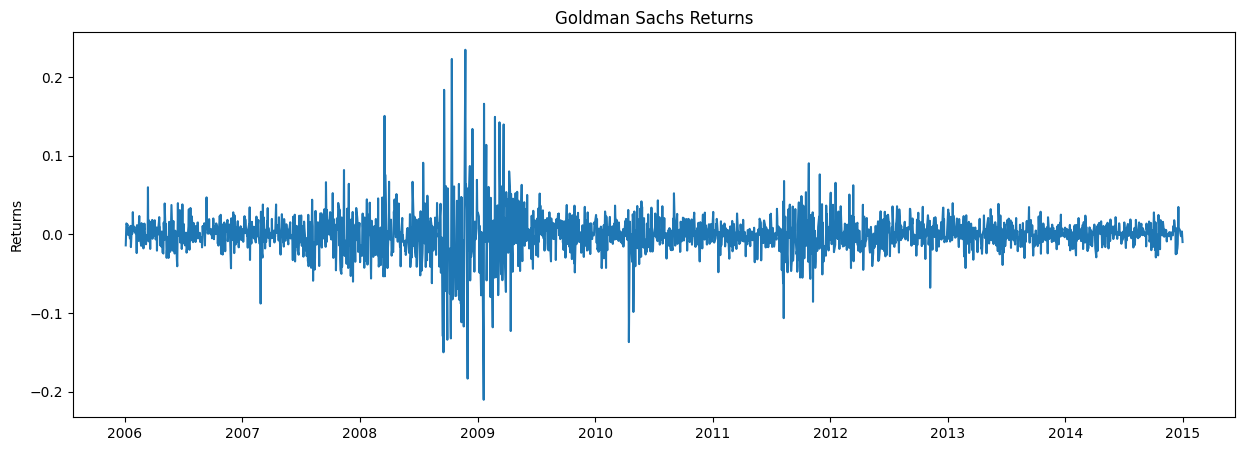

In [7]:
#gs = DataReader('GS',  'yahoo', datetime(2006,1,1), datetime(2015,1,1))
gs = yf.download("GS", start=START, end=END, progress=False)
gs_returns = pd.DataFrame(np.diff(np.log(gs['Close'].values.ravel())))
gs_returns.index = gs.index.values[1:gs.index.values.shape[0]]
gs_returns.columns = ['Goldman Sachs Returns']

plt.figure(figsize=(15,5))
plt.plot(gs_returns)
plt.ylabel('Returns')
plt.title('Goldman Sachs Returns')
plt.show()

Now let us calculate the variance and the correlation between this stock and our previous stock:

In [8]:
gs_std = (gs_returns.std()).values[0]
jpm_std = (jpm_returns.std()).values[0]
returns = pd.concat([jpm_returns,gs_returns],axis=1)
corr = returns.corr().iloc[0,1]

weighted_average = 0.5*gs_std + 0.5*jpm_std

actual = np.sqrt(np.power(0.5*gs_std,2) + np.power(0.5*jpm_std,2) + 2*(0.5*gs_std)*(0.5*jpm_std)*corr)

print("Correlation is " + str(corr))
print("Weighted average std is " + str(weighted_average))
print("Actual std is " + str(actual))

Correlation is 0.738516677041666
Weighted average std is 0.027350833894119308
Actual std is 0.025503969861259405


The two quantities above will only be equal if both stocks are perfectly correlated. Else, $\sigma_{p} \leq 0.5\sigma_{1} + 0.5\sigma_{2}$. This is the key to diversification: the risk of the whole can be less than the sum of its parts. We can visualize the effect of diversification for a two stock example as follows:

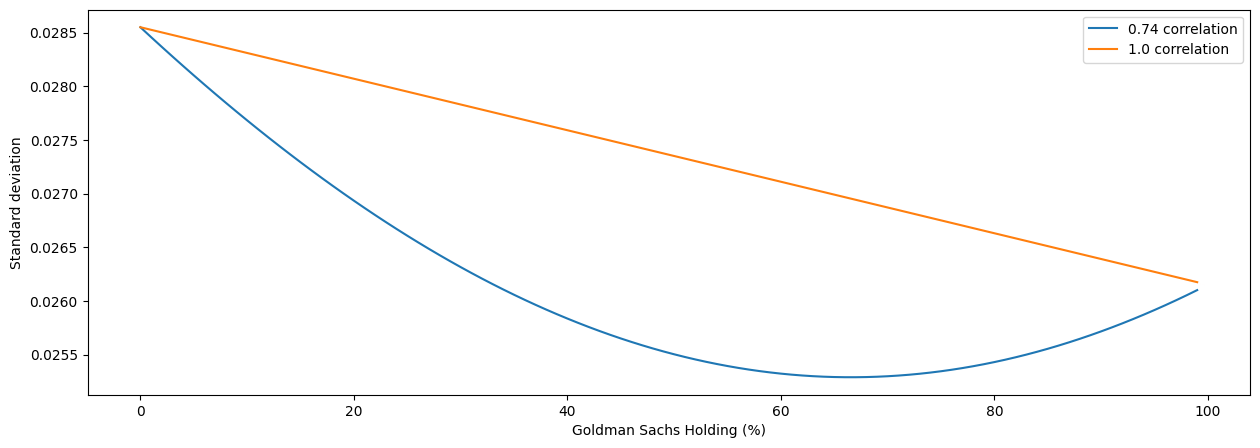

In [9]:
def portfolio_std(s1_std, s2_std, s1s2_corr, s1_h=0.5):
    return np.sqrt(np.power(s1_h*s1_std,2) + np.power((1-s1_h)*s2_std,2)
                   + 2 * (s1_h*s1_std) * ((1-s1_h)*s2_std) * s1s2_corr)

portfolio_risk = [portfolio_std(gs_std,jpm_std,corr,h/100) for h in range(0,100)]
perfect_corr_risk = [portfolio_std(gs_std,jpm_std,1,h/100) for h in range(0,100)]

plt.figure(figsize=(15,5))
plt.plot(portfolio_risk,label=str(round(corr,2)) + " correlation")
plt.plot(perfect_corr_risk,label=str(1.00) + " correlation")
plt.xlabel("Goldman Sachs Holding (%)")
plt.ylabel("Standard deviation")
plt.legend()
plt.show()

Suppose we have a portfolio of $N$ stocks each with risk $\sigma$ and uncorrelated returns. What would the risk of an equally weighted portfolio of these stocks be?

$$\sigma_{p} = \sqrt{  \sum_{i=1}^{N}(\frac{1}{N}\sigma)^{2} } = \sqrt{  N(\frac{1}{N}\sigma)^{2} } = \sqrt{  N} \frac{1}{N}\sigma = \frac{\sigma}{\sqrt{N}}$$

Unfortunately it is quite difficult to find uncorrelated stocks. Let's assume the correlation between the returns of all pairs of stocks is $\rho$. The variance of an equally weighted portfolio is:

$$\sigma_{p} = \sqrt{  \sum_{i=1}^{N}(\frac{1}{N}\sigma)^{2} + \frac{N(N-1)}{2}2\frac{1}{N^{2}}\sigma^{2}\rho}$$

$$\sigma_{p} = \sqrt{    \frac{1}{N}\sigma^{2}  + \frac{N(N-1)}{2}2\frac{1}{N^{2}}\sigma^{2}\rho}$$

$$\sigma_{p} = \sigma\sqrt{    \frac{1}{N}  + \frac{N(N-1)}{2}2\frac{1}{N^{2}}\rho}$$

$$\sigma_{p} = \sigma\sqrt{    \frac{1}{N}  + \frac{N(N-1)}{2}2\frac{1}{N^{2}}\rho}$$
$$\sigma_{p} = \sigma\sqrt{ \frac{1 + \rho(N-1)}{N}}$$

As $N \to \infty$, $\sigma_{p} \to \sigma\sqrt\rho$. Let's get a feel for this by loading a large set of stocks:

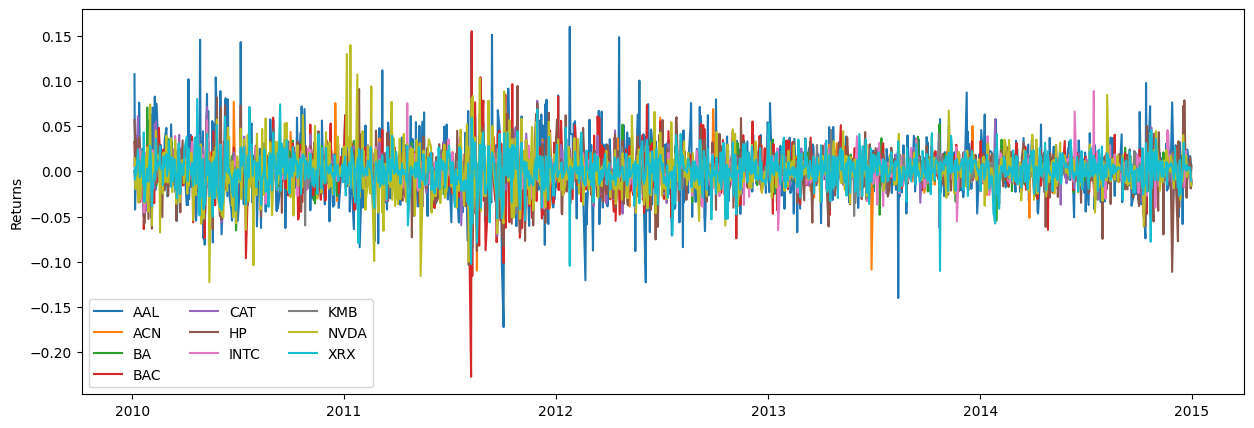

In [10]:
stock_list = ['ACN', 'BA', 'BAC', 'CAT', 'HP', 'INTC', 'KMB', 'NVDA', 'AAL', 'XRX']
stocks = yf.download(stock_list, start="2010-01-01", end=END, progress=False)
#stocks = DataReader(list,  'yahoo', datetime(2010,1,1), datetime(2015,1,1))
return_df = pd.DataFrame(np.diff(np.log(stocks['Close']).T).T)
return_df.index = stocks['Close'].index[1:]
return_df.columns = stocks['Close'].columns
plt.figure(figsize=(15,5))
handles = plt.plot(return_df)
plt.ylabel('Returns')
plt.legend(handles=handles, labels=list(return_df.columns), ncol=3)
plt.show()

We can obtain the historical covariance-variance matrix as follows:

In [11]:
cov = return_df.cov()
cov

Ticker,AAL,ACN,BA,BAC,CAT,HP,INTC,KMB,NVDA,XRX
Ticker,,,,,,,,,,
AAL,0.001085,0.000120,0.000177,0.000318,0.000198,0.000179,0.000150,0.000067,0.000222,0.000189
ACN,0.000120,0.000211,0.000115,0.000161,0.000134,0.000162,0.000100,0.000044,0.000150,0.000142
BA,0.000177,0.000115,0.000236,0.000194,0.000154,0.000176,0.000106,0.000054,0.000159,0.000157
BAC,0.000318,0.000161,0.000194,0.000581,0.000234,0.000275,0.000151,0.000061,0.000248,0.000234
CAT,0.000198,0.000134,0.000154,0.000234,0.000302,0.000250,0.000132,0.000052,0.000204,0.000187
HP,0.000179,0.000162,0.000176,0.000275,0.000250,0.000545,0.000150,0.000058,0.000256,0.000226
INTC,0.000150,0.000100,0.000106,0.000151,0.000132,0.000150,0.000217,0.000042,0.000174,0.000141
KMB,0.000067,0.000044,0.000054,0.000061,0.000052,0.000058,0.000042,0.000077,0.000045,0.000059
NVDA,0.000222,0.000150,0.000159,0.000248,0.000204,0.000256,0.000174,0.000045,0.000576,0.000212


The variance of a portfolio is calculated as $h^{T}Vh$ where $h$ is a $(K,1)$ vector of portfolio weights. We will assume an equally-weighted portfolio:

In [12]:
h = np.ones(len(stock_list)) * (1 / len(stock_list))
p_std = np.sqrt(np.dot(np.dot(np.transpose(h),cov),h))
equal_std = np.dot(h,np.sqrt(np.diag(cov)))
print("Portfolio standard deviation is " + str(p_std))
print("Equally weighted standard deviation is " + str(equal_std))

Portfolio standard deviation is 0.013500519423877637
Equally weighted standard deviation is 0.019413061323883284


Our equation implies an average correlation between these stocks of around:

In [13]:
print(np.power(p_std/equal_std,2))

0.4836296330349358


While standard deviations (defined here as risk) don't add across stocks or time, variance will add across time if returns are uncorrelated from one interval to a next. This would mean variances would grow with the length of the forecast horizon and standard deviations will grow with the square root of the forecast horizon. So a 5% annual active risk is equivalent to a 2.5% active risk over the first quarter or a 10% active risk over four years. The variance (6.25, 25, 100) remains proportional to the length of the horizon.

To annualize the risk we calculate:

$\sigma_{annual} = \sqrt{12}\sigma_{monthly}$

## Relative and Active Risk

### Active Risk

In practice a manager might be judged on their return and risk *relative* to a benchmark. We define:

- Active return $r_{PA} = r_{P} - r_{B}$
- Active risk $\psi_{P} = Std\left(r_{PA}\right) = Std\left(r_{P}-r_{B}\right)$

Where $r_{P}$ is the return of the manager and $r_{B}$ is the return of the benchmark. The active risk is sometimes known as the tracking error of the portfolio as it describes how well the portfolio can track the benchmark.

To see an example, go back to our dual JPM/GS example and assume our benchmark is 60 percent GS and 40 percent JPM

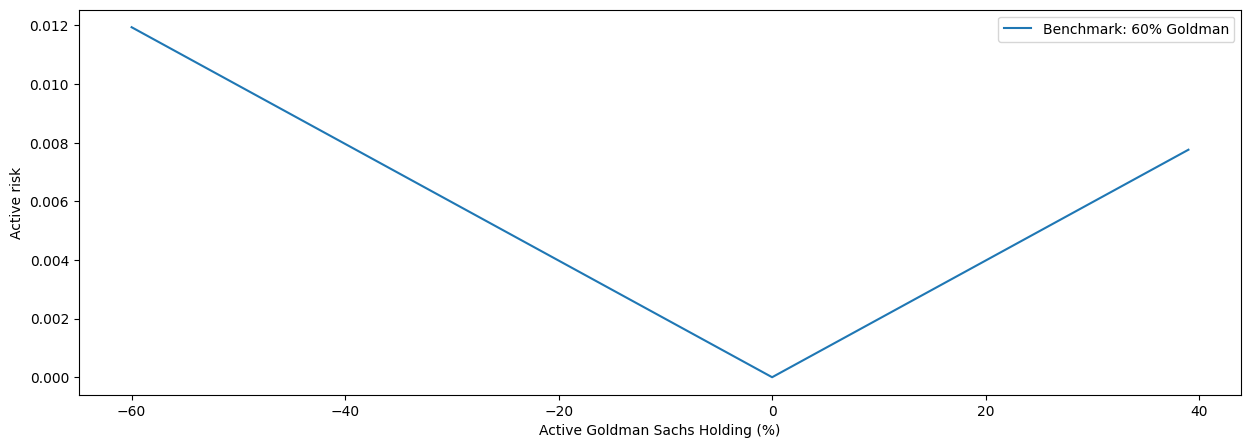

In [14]:
benchmark_weight = 0.6
portfolio_risk = portfolio_std(gs_std,jpm_std,corr,benchmark_weight)
benchmark_returns = benchmark_weight*gs_returns.values + (1-benchmark_weight)*jpm_returns.values
active_risks = [(((h/100)*gs_returns.values+(1-(h/100))*jpm_returns.values) - benchmark_returns).std() 
                 for h in range(0,100)]

plt.figure(figsize=(15,5))
plt.plot(range(-60,40),active_risks,label="Benchmark: 60% Goldman")
plt.xlabel("Active Goldman Sachs Holding (%)")
plt.ylabel("Active risk")
plt.legend()

### Residual Risk

Residual risk is the risk of return orthogonal to the systematic return. The residual risk of portfolio $P$ relative to portfolio $B$ is denoted by $\omega_{P}$ and defined by:

$$\omega_{P} = \sqrt{\sigma_{P}^{2} - \beta_{P}^{2}\sigma_{B}^{2}}$$

This comes from the model $r_{P} = \beta_{P}r_{B} + \theta_{B}$ and the lack of correlation between the residual and market returns. Let's calculate the $\beta$s for the return data we have. We first need to convert to excess returns by subtracting the risk-free rate, and we need to load the benchmark (S&P500):

In [15]:
one_mon = DataReader('DGS1MO', 'fred',datetime(2006,1,1), datetime(2015,1,1))
one_day = np.log(1+one_mon)/365

#spy = DataReader('SPY',  'yahoo', datetime(2006,1,1), datetime(2015,1,1))
spy = yf.download("SPY", start=START, end=END, progress=False)
spy_returns = pd.DataFrame(np.diff(np.log(spy['Close'].values.ravel())))
spy_returns.index = spy.index.values[1:spy.index.values.shape[0]]
spy_returns.columns = ['S&P500']

excess_returns = pd.concat([one_day,return_df,spy_returns],axis=1).dropna()
excess_returns = excess_returns.subtract(excess_returns['DGS1MO'].values,axis=0)

Next we calculate the betas:

In [16]:
def get_beta(stock,market):
    exog = sm.add_constant(market, prepend=True)
    mod = sm.OLS(stock, exog)
    #return mod.fit().params[1]
    return mod.fit().params.iloc[1]

def get_residual_risk(benchmark_std,stock_beta,stock_std):
    return np.sqrt(np.power(stock_std,2) - np.power(stock_beta*benchmark_std,2))

def get_risk_measures(excess_rets):
    tickers,beta_list,total_risk,residual_risk = ([] for _ in range(4))
    tickers = []
    for stock in excess_rets.columns:
        mkt_risk = excess_rets['S&P500'].std()
        if stock not in ['DGS1MO','S&P500']:
            beta = get_beta(excess_rets[stock], excess_rets['S&P500'])
            stock_risk = excess_rets[stock].std()
            total_risk.append(stock_risk)
            residual_risk.append(get_residual_risk(mkt_risk,beta,stock_risk))
            beta_list.append(beta)
            tickers.append(stock)
    results = pd.DataFrame(np.array([beta_list,total_risk,residual_risk]).T)
    results.index = tickers
    results.columns = ['Betas','Total Risk','Residual Risk']
    return results

risk_summary = get_risk_measures(excess_returns)
risk_summary

,Betas,Total Risk,Residual Risk
AAL,1.469136,0.032968,0.029526
ACN,1.001261,0.014493,0.010495
BA,1.126473,0.015354,0.010454
BAC,1.746525,0.024121,0.016669
CAT,1.359796,0.017348,0.010802
HP,1.603453,0.023260,0.016876
INTC,0.971530,0.014755,0.011119
KMB,0.470336,0.008792,0.007434
NVDA,1.424608,0.024022,0.019360
XRX,1.350763,0.018959,0.013327


Variance in the book measures the cost of risk. The cost of risk equates risk to an equivalent loss in expected return. The book associates the cost of risk with active or residual return. An example for a risk aversion coefficient of 0.1 is shown below:

Text(0, 0.5, 'Return Tradeoff (%)')

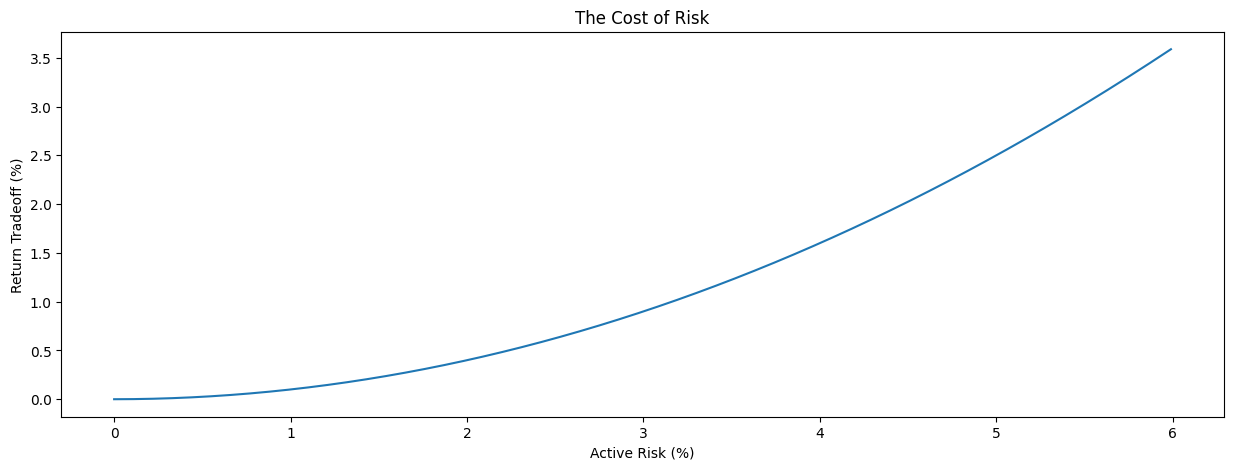

In [17]:
risk_aversion = 0.1
active_risk = np.array([i/100 for i in range(0,600)])
return_tradeoff = risk_aversion*np.power(active_risk,2)
plt.figure(figsize=(15,5))
plt.plot(active_risk,return_tradeoff)
plt.title("The Cost of Risk")
plt.xlabel("Active Risk (%)")
plt.ylabel("Return Tradeoff (%)")

So a 4% active risk produces a 1.6% loss in expected return (given this investor's preferences over risk).

## Elementary Risk Models

There is a significant problem in calculating portfolio risk. As we increase the size of the portfolio, we the number of covariance estimates we require increases exponentially; specifically, we need $N(N-1)/2$ correlations. The 505 stocks on the S&P500 are highlighted (127,260 covariances are needed).

(0.0, 180000.0)

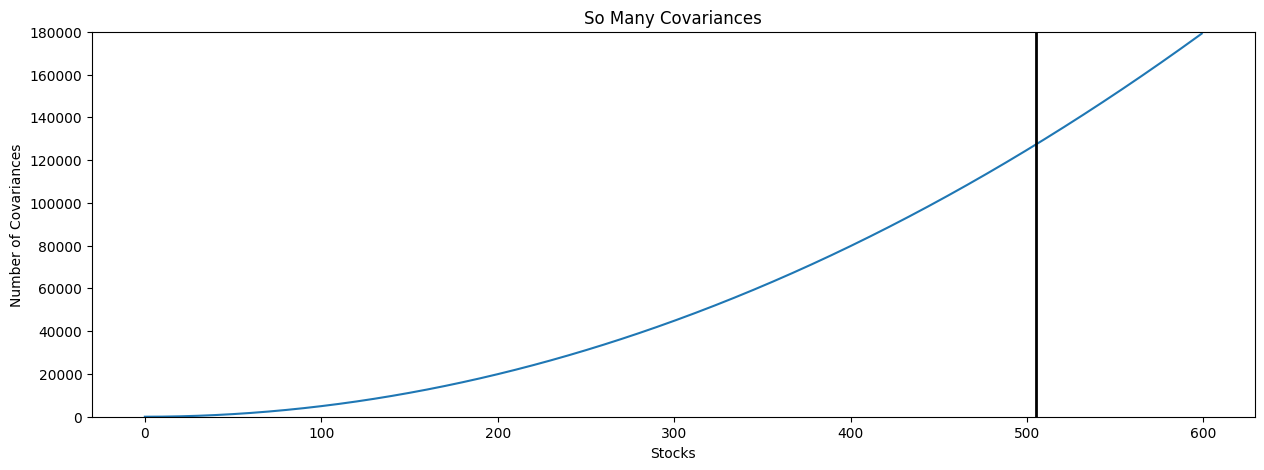

In [18]:
stock_no = np.array([i for i in range(0,600)])
correlations = np.array([i*(i-1)/2 for i in range(0,600)])
plt.figure(figsize=(15,5))
plt.plot(stock_no,correlations)
plt.title("So Many Covariances")
plt.xlabel("Stocks")
plt.ylabel("Number of Covariances")
plt.plot([505, 505], [0, 500000], 'k-', lw=2)
plt.ylim(0,180000)

It is a challenge to estimate so many quantities accurately - since we will perform portfolio optimization, even if only a small percentage of the estimates are wrong, they will severely impact the choice.

** The goal of a risk model is to accurately and efficiently forecast the covariance matrix**

There are three elementary stock risk models:
- The single-factor diagonal model
- The common correlation model
- The historical returns model

### The Single-Factor Diagonal Model

The single-factor model of risk was a precursor to CAPM but both models are distinct. It analyses returns as:

$$ r_{n} = \beta_{n}r_{M} + \theta_{n}  $$

Where $\beta_{n}$ is stock *n*'s beta and $\theta_{n}$ is the residual return. The single-factor risk model assumes that the residual returns $\theta_{n}$  are uncorrelated and therefore:

$$ Cov(r_{n},r_{m}) = \beta_{n}\beta_{m}\sigma^{2}_{M} $$
$$ \sigma^{2}_{n} = \beta^{2}_{n}\sigma^{2}_{M} + \omega^{2}_{n}$$

Let's calculate the covariance matrix for the stocks we had earlier:

In [19]:
betas = risk_summary['Betas'].values
market_risk = excess_returns['S&P500'].std()
residual_risks = risk_summary['Residual Risk'].values

def single_factor_covariance(beta_list, mkt_risk, resid_risks, tickers=None):
    beta_vector = np.array([beta_list])
    cov_matrix = np.dot(beta_vector.T,beta_vector)
    cov_matrix = cov_matrix*np.power(mkt_risk, 2)
    cov_matrix[np.diag_indices_from(cov_matrix)] = np.diag(cov_matrix)+np.power(resid_risks, 2)
    results = pd.DataFrame(cov_matrix)
    
    if tickers is not None:
        results.index = tickers
        results.columns = tickers
        
    return results

sf_covmatrix = single_factor_covariance(betas,market_risk,residual_risks,risk_summary.index)
sf_covmatrix

,AAL,ACN,BA,BAC,CAT,HP,INTC,KMB,NVDA,XRX
AAL,0.001087,0.000147,0.000165,0.000256,0.000199,0.000235,0.000142,0.000069,0.000209,0.000198
ACN,0.000147,0.000210,0.000112,0.000174,0.000136,0.000160,0.000097,0.000047,0.000142,0.000135
BA,0.000165,0.000112,0.000236,0.000196,0.000153,0.000180,0.000109,0.000053,0.000160,0.000152
BAC,0.000256,0.000174,0.000196,0.000582,0.000237,0.000279,0.000169,0.000082,0.000248,0.000235
CAT,0.000199,0.000136,0.000153,0.000237,0.000301,0.000217,0.000132,0.000064,0.000193,0.000183
HP,0.000235,0.000160,0.000180,0.000279,0.000217,0.000541,0.000155,0.000075,0.000228,0.000216
INTC,0.000142,0.000097,0.000109,0.000169,0.000132,0.000155,0.000218,0.000046,0.000138,0.000131
KMB,0.000069,0.000047,0.000053,0.000082,0.000064,0.000075,0.000046,0.000077,0.000067,0.000063
NVDA,0.000209,0.000142,0.000160,0.000248,0.000193,0.000228,0.000138,0.000067,0.000577,0.000192
XRX,0.000198,0.000135,0.000152,0.000235,0.000183,0.000216,0.000131,0.000063,0.000192,0.000359


The problem with this model is that residual returns *are* correlated. The market-weighted average of residual returns is exactly zero:

$$ \sum_{n}h_{M}(n)\theta_{n} = 0 $$

As a result the residual correlation between stocks must be in general negative. To see this we assume there are two stocks with equal market capitalization. The equation above implies $\theta_{2} = -\theta_{1}$ so there is 100% negative correlation. As the number of stocks $n$ increases the average negative correlation decreases towards 0. In practice, we should expect positive residual correlation among stocks in the same industry. The reasons why this simple model may still be attractive:

- It isolates market and residual risk
- It gives a conservative estimate of the residual covariance between stocks (0)

### The Common Correlation Model

This model requires an estimate of each stock's risk $\sigma_{n}$ and an average stock correlation $\rho$. This implies that the covariance between any 2 stocks is:

$$ Cov(r_{n},r_{m}) = \sigma_{m}\sigma_{n}\rho $$

Let's just use the risk estimates from the historical covariance matrix we estimated earlier along with the implied figure we had for average correlation:

In [20]:
residual_risks = risk_summary['Residual Risk'].values

def common_correlation_covariance(stock_risks,correlation,tickers=None):
    stock_risks = np.array([stock_risks])
    cov_matrix = np.dot(stock_risks.T,stock_risks)
    cov_matrix = cov_matrix*correlation
    cov_matrix[np.diag_indices_from(cov_matrix)] = np.diag(cov_matrix)/correlation
    results = pd.DataFrame(cov_matrix)
    
    if tickers is not None:
        results.index = tickers
        results.columns = tickers
            
    return results
    
cc_covmatrix = common_correlation_covariance(risk_summary['Total Risk'].values,0.511708472128,risk_summary.index)
cc_covmatrix

,AAL,ACN,BA,BAC,CAT,HP,INTC,KMB,NVDA,XRX
AAL,0.001087,0.000245,0.000259,0.000407,0.000293,0.000392,0.000249,0.000148,0.000405,0.000320
ACN,0.000245,0.000210,0.000114,0.000179,0.000129,0.000173,0.000109,0.000065,0.000178,0.000141
BA,0.000259,0.000114,0.000236,0.000190,0.000136,0.000183,0.000116,0.000069,0.000189,0.000149
BAC,0.000407,0.000179,0.000190,0.000582,0.000214,0.000287,0.000182,0.000109,0.000297,0.000234
CAT,0.000293,0.000129,0.000136,0.000214,0.000301,0.000206,0.000131,0.000078,0.000213,0.000168
HP,0.000392,0.000173,0.000183,0.000287,0.000206,0.000541,0.000176,0.000105,0.000286,0.000226
INTC,0.000249,0.000109,0.000116,0.000182,0.000131,0.000176,0.000218,0.000066,0.000181,0.000143
KMB,0.000148,0.000065,0.000069,0.000109,0.000078,0.000105,0.000066,0.000077,0.000108,0.000085
NVDA,0.000405,0.000178,0.000189,0.000297,0.000213,0.000286,0.000181,0.000108,0.000577,0.000233
XRX,0.000320,0.000141,0.000149,0.000234,0.000168,0.000226,0.000143,0.000085,0.000233,0.000359


This model is "quick and dirty" - it ignores linkages between stocks in similar industries and those with similar attributes.

### The Historical Covariance Model

This approach relies on historical variances and covariances. This approach is not robust for a large number of stocks. If the length of the time series $T\leq{N}$ we can find risk-less positions. This is because an $N x N$ covariance matrix with $T$ periods of return has rank equal to $\min(N,T-1)$. (With $N$ stocks and $T$ periods we have $NT$ observations so we require, for a minimum of two observations per estimate, $T\geq(N+1)$). If we had monthly returns then we would require more than 40 years of data to construct a monthly historical covariance matrix. Even if these conditions are satisfied, the historical approach has problems:

- Historical risk cannot deal with the changing nature of a company due to mergers and spin-offs.
- Selection bias as takeovers, LBOs and failed companies are omitted.
- Sample bias can lead to gross mis-estimates of covariance. For a 500 asset covariance matrix, with 125,250 independent numbers, if 5% of these are wrong then there are 6,262 poor estimates.

We reproduce our historical matrix below:

In [21]:
cov

Ticker,AAL,ACN,BA,BAC,CAT,HP,INTC,KMB,NVDA,XRX
Ticker,,,,,,,,,,
AAL,0.001085,0.000120,0.000177,0.000318,0.000198,0.000179,0.000150,0.000067,0.000222,0.000189
ACN,0.000120,0.000211,0.000115,0.000161,0.000134,0.000162,0.000100,0.000044,0.000150,0.000142
BA,0.000177,0.000115,0.000236,0.000194,0.000154,0.000176,0.000106,0.000054,0.000159,0.000157
BAC,0.000318,0.000161,0.000194,0.000581,0.000234,0.000275,0.000151,0.000061,0.000248,0.000234
CAT,0.000198,0.000134,0.000154,0.000234,0.000302,0.000250,0.000132,0.000052,0.000204,0.000187
HP,0.000179,0.000162,0.000176,0.000275,0.000250,0.000545,0.000150,0.000058,0.000256,0.000226
INTC,0.000150,0.000100,0.000106,0.000151,0.000132,0.000150,0.000217,0.000042,0.000174,0.000141
KMB,0.000067,0.000044,0.000054,0.000061,0.000052,0.000058,0.000042,0.000077,0.000045,0.000059
NVDA,0.000222,0.000150,0.000159,0.000248,0.000204,0.000256,0.000174,0.000045,0.000576,0.000212


### Which model performed better out-of-sample?

We can look at squared losses for each matrix out-of-sample:

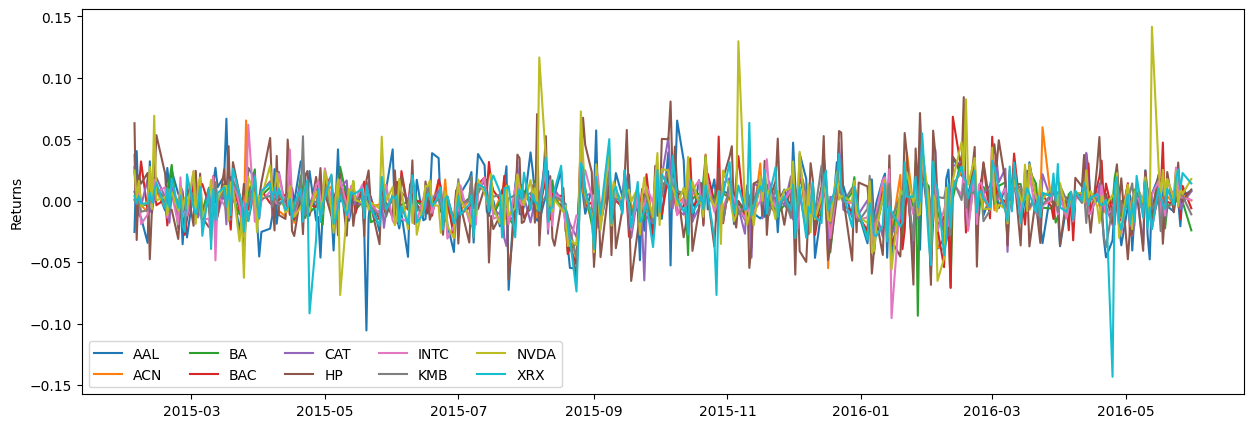

In [22]:
#stocks_oos = DataReader(stock_list, 'yahoo', datetime(2015, 2, 1), datetime(2016, 6, 1))
stocks_oos = yf.download(stock_list, start=START_EX, end=END_EX, progress=False)

return_df_oos = pd.DataFrame(np.diff(np.log(stocks_oos['Close']).T).T)
return_df_oos.index = stocks_oos['Close'].index[1:]
return_df_oos.columns = stocks_oos['Close'].columns

plt.figure(figsize=(15,5))
handle = plt.plot(return_df_oos)
plt.ylabel('Returns')
plt.legend(handle, return_df_oos.columns, ncol=5)
plt.show()

In [23]:
realized_cov = return_df_oos.cov()
realized_cov

Ticker,AAL,ACN,BA,BAC,CAT,HP,INTC,KMB,NVDA,XRX
Ticker,,,,,,,,,,
AAL,0.000497,0.000106,0.000136,0.000144,0.000085,0.000067,0.000139,0.000091,0.000162,0.000132
ACN,0.000106,0.000178,0.000113,0.000142,0.000107,0.000125,0.000113,0.000073,0.000130,0.000122
BA,0.000136,0.000113,0.000231,0.000147,0.000127,0.000154,0.000114,0.000086,0.000114,0.000143
BAC,0.000144,0.000142,0.000147,0.000329,0.000162,0.000213,0.000144,0.000078,0.000163,0.000173
CAT,0.000085,0.000107,0.000127,0.000162,0.000278,0.000307,0.000124,0.000064,0.000089,0.000153
HP,0.000067,0.000125,0.000154,0.000213,0.000307,0.000770,0.000162,0.000070,0.000113,0.000223
INTC,0.000139,0.000113,0.000114,0.000144,0.000124,0.000162,0.000243,0.000067,0.000177,0.000123
KMB,0.000091,0.000073,0.000086,0.000078,0.000064,0.000070,0.000067,0.000116,0.000064,0.000081
NVDA,0.000162,0.000130,0.000114,0.000163,0.000089,0.000113,0.000177,0.000064,0.000511,0.000141


In [24]:
equal_ensemble = (1/3)*cov + (1/3)*cc_covmatrix + (1/3)*sf_covmatrix

historical_loss = np.power(realized_cov-cov,2).sum().sum()
cc_loss = np.power(realized_cov-cc_covmatrix,2).sum().sum()
sf_loss = np.power(realized_cov-sf_covmatrix,2).sum().sum()
ens_loss = np.power(realized_cov-equal_ensemble,2).sum().sum()

loss_results = pd.DataFrame([historical_loss,cc_loss,sf_loss,ens_loss])
loss_results.index = ['Historical Covariance','Constant Correlation Covariance','Single Factor Covariance','Equal Ensemble Covariance']
loss_results.columns = ['Squared Loss']
loss_results

,Squared Loss
Historical Covariance,7.518696e-07
Constant Correlation Covariance,1.428592e-06
Single Factor Covariance,7.412190e-07
Equal Ensemble Covariance,8.953054e-07


The **single factor** model had the best performance!

## Structural Risk Models
_Structural risk models decompose risk into_
 - total risk
 - active risk
 - market (or benchmark)
 - residual risk

_Structural risk models reduce considerably_<br>
 (e.g. compared to e.g. the 60-month beta regression)! The size of the variances / co-variances by grouping stocks to a manageable number of standard (e.g. ~ 70) factors.
 - stocks change
 - factors do not change

_Historical regressions have the following problems_
 - relying on T periods to estimate N by N covariance matrix requires short time periods while forecast horizons are often one quarter to one year
 - cant deal with changing nature of company (mergers / splits)
 - selection bias as takeovers / failed companies omitted
 - sample bias will lead to some gross mis-estimates of co-variances (e.g. 500 x 500 co-var if 5% of estimates poor that's 6262 poor estimates)